In [5]:
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [6]:

df = pd.concat(map(pd.read_csv, ['Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 
                                 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
                                 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 
                                 'Monday-WorkingHours.pcap_ISCX.csv', 
                                 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 
                                 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 
                                 'Tuesday-WorkingHours.pcap_ISCX.csv', 
                                 'Wednesday-workingHours.pcap_ISCX.csv']), 
               ignore_index = True)

print("Datatype of Dataframe i.e. Pandas Dataframe: ", type(df))
print("Datatype of Column i.e. Pandas Series: ", type(df.iloc[:, 1]))
df.head()

Datatype of Dataframe i.e. Pandas Dataframe:  <class 'pandas.core.frame.DataFrame'>
Datatype of Column i.e. Pandas Series:  <class 'pandas.core.series.Series'>


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
def data_cleaning(df):
    df.columns=df.columns.str.strip()
    print("Dataset Shape: ",df.shape)
    
    num=df._get_numeric_data()
    num[num<0]=0
    
    
    zero_variance_cols=[]
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(columns=zero_variance_cols,axis=1,inplace=True)
    print("Zero Variance Columns: ",zero_variance_cols, " are dropped!!")
    print("Shape after removing the zero variance columns: ",df.shape)
    
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    print(df.isna().any(axis=1).sum(), "rows dropped")
    df.dropna(inplace=True)
    print("Shape after Removing NaN: ",df.shape)
    
    df.drop_duplicates(inplace=True)
    print("Shape after dropping duplicates: ",df.shape)
    
    column_pairs = [(i,j) for i,j in combinations(df,2) if df[i].equals(df[j])]
    ide_cols=[]
    for col_pair in column_pairs:
        ide_cols.append(col_pair[1])
    df.drop(columns=ide_cols,axis=1,inplace=True)
    print("Columns which have identical values: ",column_pairs," dropped!")
    print("Shape after removing identical value columns: ",df.shape)
    return df
df=data_cleaning(df)
    

Dataset Shape:  (2830743, 79)
Zero Variance Columns:  ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']  are dropped!!
Shape after removing the zero variance columns:  (2830743, 71)
2867 rows dropped
Shape after Removing NaN:  (2827876, 71)
Shape after dropping duplicates:  (2520798, 71)
Columns which have identical values:  [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1')]  dropped!
Shape after removing identical value columns:  (2520798, 66)


In [8]:
df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

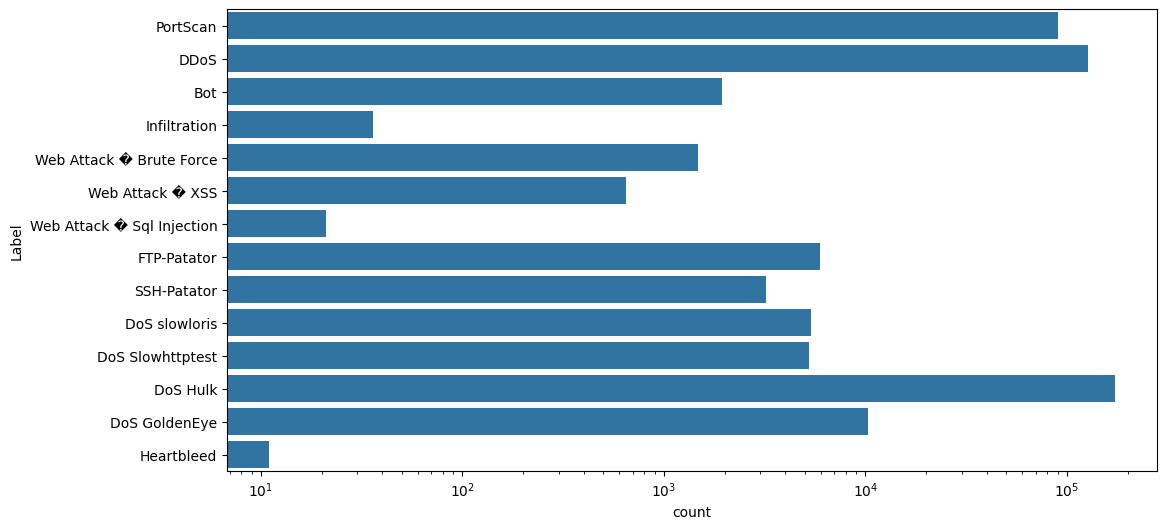

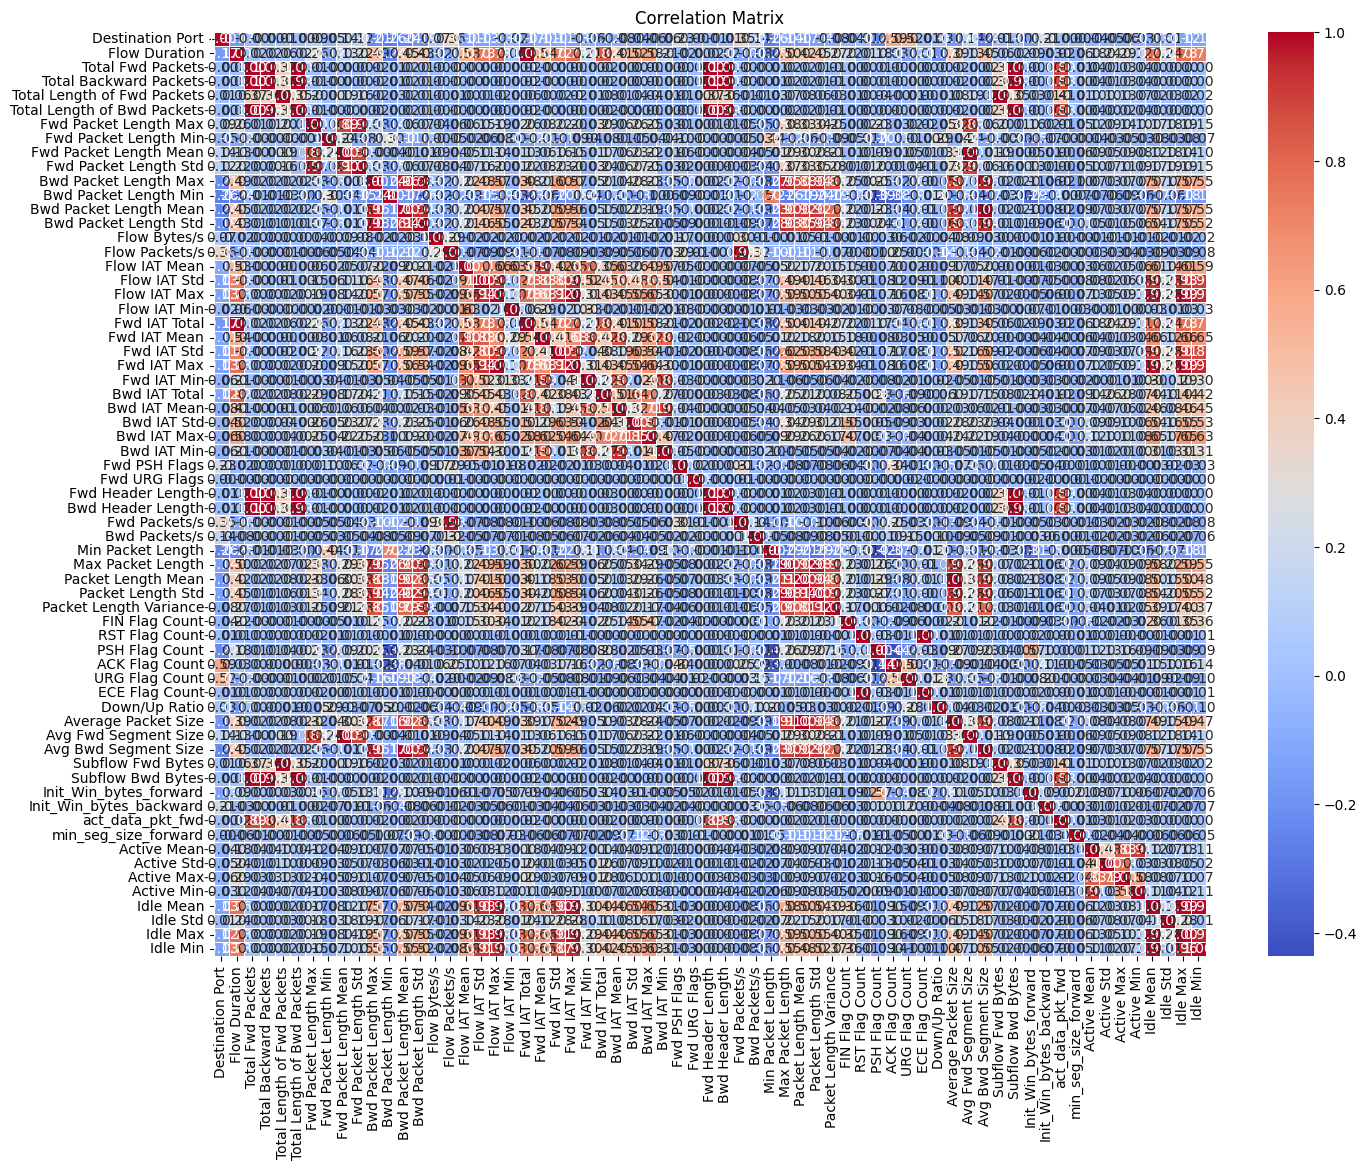

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Assuming 'Label' is the column you want to plot
plot = sns.countplot(data=df[df['Label'] != 'BENIGN'], y='Label')
plt.xscale('log')
fig = plot.get_figure()

# Exclude non-numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_columns]

# Calculate the correlation matrix for numeric columns
correlation_matrix = df_numeric.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')



plt.show()


In [9]:
df.columns=df.columns.str.strip().str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','')
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [10]:
new_df=df.copy()

In [11]:
df_cleaned = new_df.reset_index()

df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned
df.columns.tolist()

['destination_port',
 'flow_duration',
 'total_fwd_packets',
 'total_backward_packets',
 'total_length_of_fwd_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_min',
 'fwd_packet_length_mean',
 'fwd_packet_length_std',
 'bwd_packet_length_max',
 'bwd_packet_length_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_std',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_psh_flags',
 'fwd_urg_flags',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'bwd_packets/s',
 'min_packet_length',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'fin_flag_count',
 'rst_flag_count',
 'psh_flag_count',
 'ack_flag_count',
 'urg_flag_count',
 'ece_flag_count',
 'down/up_ratio',
 'a

In [12]:

df_labels = df_cleaned['label']
df_labels.unique()

array(['BENIGN', 'PortScan', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [13]:
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)

# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520793,53,32215,4,2,112,152,28,28,28.000000,0.000000,...,3,20,0.0,0.0,0,0,0.0,0.0,0,0
2520794,53,324,2,2,84,362,42,42,42.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2520795,58030,82,2,1,31,6,31,0,15.500000,21.920310,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
2520796,53,1048635,6,2,192,256,32,32,32.000000,0.000000,...,5,20,0.0,0.0,0,0,0.0,0.0,0,0


In [14]:
df_scaled = StandardScaler().fit_transform(df_no_labels)
# Converting back to dataframe
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)
df_scaled

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.455935,-0.434972,0.038668,0.030681,0.193804,-0.004666,0.297168,-0.315856,0.007520,0.109610,...,0.026676,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764
1,-0.455935,-0.433468,0.038668,0.030681,0.193804,-0.004666,0.297168,-0.315856,0.007520,0.109610,...,0.026676,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764
2,-0.455935,-0.470910,-0.011684,-0.010003,-0.057795,-0.007566,-0.305707,-0.315856,-0.324746,-0.260452,...,-0.008911,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764
3,-0.455935,-0.433918,0.038668,0.028789,0.199849,-0.004800,0.297168,-0.315856,0.015503,0.110504,...,0.026676,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764
4,1.404602,-0.470912,-0.011684,-0.009057,-0.057795,-0.007566,-0.305707,-0.315856,-0.324746,-0.260452,...,-0.008911,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520793,-0.454304,-0.470000,-0.007907,-0.009057,-0.047217,-0.007503,-0.268688,0.144683,-0.181562,-0.260452,...,-0.004462,-0.901945,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764
2520794,-0.454304,-0.470905,-0.010425,-0.009057,-0.049862,-0.007415,-0.250179,0.374953,-0.109970,-0.260452,...,-0.007428,-0.901945,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764
2520795,2.595063,-0.470912,-0.010425,-0.010003,-0.054867,-0.007563,-0.264722,-0.315856,-0.245484,-0.186617,...,-0.008911,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764
2520796,-0.454304,-0.441151,-0.005390,-0.009057,-0.039662,-0.007459,-0.263400,0.210475,-0.161107,-0.260452,...,-0.001497,-0.901945,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764


In [15]:
def get_PCA_feature_names(num_of_pca_components):
    feature_names = []
    for i in range(num_of_pca_components):    
        feature_names.append(f"Principal component {i+1}")
    return feature_names

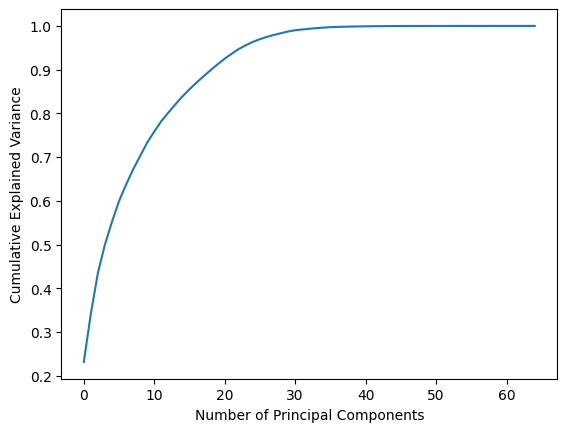

In [15]:
pca_test = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

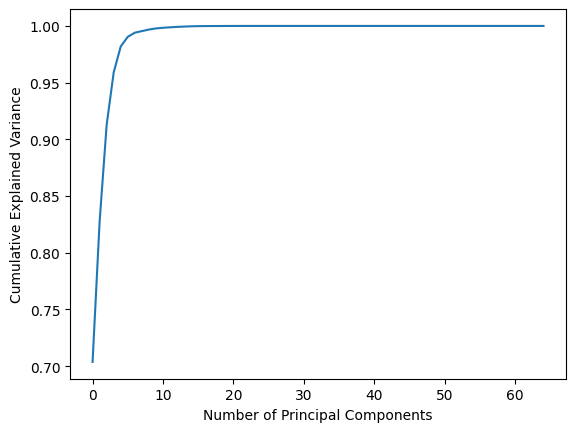

In [16]:
pca_test = PCA().fit(df_no_labels)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [16]:
dimensions_num_for_PCA = 10
pca = PCA(n_components=dimensions_num_for_PCA)
#principal_components = pca.fit(df_scaled).transform(df_scaled) => for normalised PCA

# Non-normalised PCA
principal_components = pca.fit(df_no_labels).transform(df_no_labels)
principal_components

array([[-32701653.13134192,  -2530130.8862029 ,  -1746741.20140111, ...,
           -37036.12232411,    135071.56660865,    582980.54973043],
       [-32639889.26478787,  -2470971.21594427,  -1745783.70038959, ...,
           -37767.04121463,    136519.42624886,    585219.82207132],
       [-34554660.34044485,  -2943294.61133734,  -1772899.52595939, ...,
            73342.34070714,   -210406.03155429,   -128811.99581084],
       ...,
       [-34559032.33931608,  -2949244.01669694,  -1321653.99890034, ...,
            73235.67706209,   -210248.56724827,   -128760.78717113],
       [-32909562.22601388,  -2952296.2164492 ,  -1761716.4580801 , ...,
          -155649.1829296 ,    397490.94312908,    378576.691043  ],
       [-34425092.39042503,  -2941000.3770969 ,  -1767697.02110316, ...,
            53568.96791986,   -158009.33728022,    -99137.70829963]])

In [17]:

principal_component_headings = get_PCA_feature_names(dimensions_num_for_PCA)

In [18]:
df_pc = pd.DataFrame(data = principal_components, columns = principal_component_headings)
df_pc

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10
0,-3.270165e+07,-2.530131e+06,-1.746741e+06,4.729268e+05,-347118.764034,263228.089059,16537.286322,-37036.122324,135071.566609,582980.549730
1,-3.263989e+07,-2.470971e+06,-1.745784e+06,4.552487e+05,-337045.024767,262939.599593,17299.586194,-37767.041215,136519.426249,585219.822071
2,-3.455466e+07,-2.943295e+06,-1.772900e+06,1.097690e+06,-678962.983959,-357283.712984,-193598.151426,73342.340707,-210406.031554,-128811.995811
3,-3.265172e+07,-2.489983e+06,-1.746120e+06,4.788321e+05,-354444.711214,271209.311968,19886.411086,-38044.689905,136710.785119,593587.879942
4,-3.455472e+07,-2.943260e+06,-1.772825e+06,1.097788e+06,-679014.656419,-357337.700460,-193762.828665,73345.609812,-210421.396013,-128858.459591
...,...,...,...,...,...,...,...,...,...,...
2520793,-3.450360e+07,-2.944808e+06,-1.764421e+06,1.080528e+06,-665285.362637,-334848.949425,-183809.112063,65122.693132,-188377.258107,-116549.765608
2520794,-3.456761e+07,-2.961478e+06,-3.965622e+05,1.091082e+06,-676449.098815,-356085.494000,-193182.845141,73431.812237,-209566.693298,-128655.835191
2520795,-3.455903e+07,-2.949244e+06,-1.321654e+06,1.095584e+06,-678172.651807,-356972.663831,-193558.559028,73235.677062,-210248.567248,-128760.787171
2520796,-3.290956e+07,-2.952296e+06,-1.761716e+06,5.015771e+05,-259834.597050,345924.957053,80076.321594,-155649.182930,397490.943129,378576.691043


In [19]:
df_final = pd.concat([df_pc, df_labels], axis = 1)
afe=pd.concat([df_scaled,df_labels],axis=1)
df_final
afe

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,-0.455935,-0.434972,0.038668,0.030681,0.193804,-0.004666,0.297168,-0.315856,0.007520,0.109610,...,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN
1,-0.455935,-0.433468,0.038668,0.030681,0.193804,-0.004666,0.297168,-0.315856,0.007520,0.109610,...,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN
2,-0.455935,-0.470910,-0.011684,-0.010003,-0.057795,-0.007566,-0.305707,-0.315856,-0.324746,-0.260452,...,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN
3,-0.455935,-0.433918,0.038668,0.028789,0.199849,-0.004800,0.297168,-0.315856,0.015503,0.110504,...,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN
4,1.404602,-0.470912,-0.011684,-0.009057,-0.057795,-0.007566,-0.305707,-0.315856,-0.324746,-0.260452,...,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520793,-0.454304,-0.470000,-0.007907,-0.009057,-0.047217,-0.007503,-0.268688,0.144683,-0.181562,-0.260452,...,-0.901945,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN
2520794,-0.454304,-0.470905,-0.010425,-0.009057,-0.049862,-0.007415,-0.250179,0.374953,-0.109970,-0.260452,...,-0.901945,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN
2520795,2.595063,-0.470912,-0.010425,-0.010003,-0.054867,-0.007563,-0.264722,-0.315856,-0.245484,-0.186617,...,0.937040,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN
2520796,-0.454304,-0.441151,-0.005390,-0.009057,-0.039662,-0.007459,-0.263400,0.210475,-0.161107,-0.260452,...,-0.901945,-0.13337,-0.110882,-0.158458,-0.107114,-0.375777,-0.11608,-0.381137,-0.361764,BENIGN


In [20]:
le = LabelEncoder()
df_final['label'] = le.fit_transform(df_final['label'])

df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,Principal component 8,Principal component 9,Principal component 10,label
0,-3.270165e+07,-2.530131e+06,-1.746741e+06,4.729268e+05,-347118.764034,263228.089059,16537.286322,-37036.122324,135071.566609,582980.549730,0
1,-3.263989e+07,-2.470971e+06,-1.745784e+06,4.552487e+05,-337045.024767,262939.599593,17299.586194,-37767.041215,136519.426249,585219.822071,0
2,-3.455466e+07,-2.943295e+06,-1.772900e+06,1.097690e+06,-678962.983959,-357283.712984,-193598.151426,73342.340707,-210406.031554,-128811.995811,0
3,-3.265172e+07,-2.489983e+06,-1.746120e+06,4.788321e+05,-354444.711214,271209.311968,19886.411086,-38044.689905,136710.785119,593587.879942,0
4,-3.455472e+07,-2.943260e+06,-1.772825e+06,1.097788e+06,-679014.656419,-357337.700460,-193762.828665,73345.609812,-210421.396013,-128858.459591,0
...,...,...,...,...,...,...,...,...,...,...,...
2520793,-3.450360e+07,-2.944808e+06,-1.764421e+06,1.080528e+06,-665285.362637,-334848.949425,-183809.112063,65122.693132,-188377.258107,-116549.765608,0
2520794,-3.456761e+07,-2.961478e+06,-3.965622e+05,1.091082e+06,-676449.098815,-356085.494000,-193182.845141,73431.812237,-209566.693298,-128655.835191,0
2520795,-3.455903e+07,-2.949244e+06,-1.321654e+06,1.095584e+06,-678172.651807,-356972.663831,-193558.559028,73235.677062,-210248.567248,-128760.787171,0
2520796,-3.290956e+07,-2.952296e+06,-1.761716e+06,5.015771e+05,-259834.597050,345924.957053,80076.321594,-155649.182930,397490.943129,378576.691043,0


In [50]:
from sklearn.preprocessing import LabelEncoder

# Assuming df_labels contains the original class names and df_final['label'] contains the encoded labels
original_classes = df_labels.unique()
encoded_labels = df_final['label'].unique()

# Create a LabelEncoder object and fit it to the encoded labels
label_encoder = LabelEncoder()
label_encoder.fit(encoded_labels)

# Map the encoded labels to their original class names
encoded_to_class_original = {encoded_label: original_class for encoded_label, original_class in zip(encoded_labels, original_classes)}

# Map the encoded labels to their original class names after LabelEncoder
encoded_to_class_after_encoder = {encoded_label: original_class for encoded_label, original_class in zip(label_encoder.transform(encoded_labels), original_classes)}

print("Encoded Labels to Original Class Names (Before LabelEncoder):", encoded_to_class_original)
print("Encoded Labels to Original Class Names (After LabelEncoder):", encoded_to_class_after_encoder)


Encoded Labels to Original Class Names (Before LabelEncoder): {0: 'BENIGN', 10: 'PortScan', 2: 'DDoS', 1: 'Bot', 9: 'Infiltration', 12: 'Web Attack � Brute Force', 14: 'Web Attack � XSS', 13: 'Web Attack � Sql Injection', 7: 'FTP-Patator', 11: 'SSH-Patator', 6: 'DoS slowloris', 5: 'DoS Slowhttptest', 4: 'DoS Hulk', 3: 'DoS GoldenEye', 8: 'Heartbleed'}
Encoded Labels to Original Class Names (After LabelEncoder): {0: 'BENIGN', 10: 'PortScan', 2: 'DDoS', 1: 'Bot', 9: 'Infiltration', 12: 'Web Attack � Brute Force', 14: 'Web Attack � XSS', 13: 'Web Attack � Sql Injection', 7: 'FTP-Patator', 11: 'SSH-Patator', 6: 'DoS slowloris', 5: 'DoS Slowhttptest', 4: 'DoS Hulk', 3: 'DoS GoldenEye', 8: 'Heartbleed'}


In [22]:
df_labels.value_counts()

label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [ ]:
X = balanced_data.drop(['label'], axis = 1)
y =balanced_data ['label']
y

NameError: name 'balanced_data' is not defined

In [23]:
X = df_final.drop(['label'], axis = 1)
y =df_final ['label']
y

0          0
1          0
2          0
3          0
4          0
          ..
2520793    0
2520794    0
2520795    0
2520796    0
2520797    0
Name: label, Length: 2520798, dtype: int32

In [24]:
num_of_splits_for_skf = 10
skf = StratifiedKFold(n_splits=num_of_splits_for_skf, shuffle=False)
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [25]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
    
print( 'X_train length: ', len(X_train) ) # To check if splits worked
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  2268719
y_train length:  2268719
X_test length:  252079
y_test length:  252079


In [26]:

import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Input, concatenate, Dropout, Average
from sklearn.feature_selection import SelectKBest, f_classif


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Input, concatenate, Dropout, Average
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



# Define your FuzzyLayer class
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", (int(input_shape[-1]), self.units), initializer="glorot_uniform", trainable=True)
        self.bias = self.add_weight("bias", (self.units,), initializer="zeros", trainable=True)
        super(FuzzyLayer, self).build(input_shape)

    def call(self, inputs):
        fuzzy_output = tf.matmul(inputs, self.kernel) + self.bias
        fuzzy_output = self.activation(fuzzy_output)
        return fuzzy_output

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super(FuzzyLayer, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.activation)
        })
        return config



# Feature selection using SelectKBest
num_features = 'all'
selector = SelectKBest(f_classif, k=num_features)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# One-hot encode the target variable
num_classes = len(np.unique(y_train))
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

# Base models
base_models = []

# CNN base model
cnn_input = Input(shape=(X_train_selected.shape[1], 1))
cnn_model = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_model = MaxPooling1D(pool_size=2)(cnn_model)
cnn_model = Flatten()(cnn_model)
cnn_model = Dense(64, activation='relu')(cnn_model)  # Add this line
base_models.append(Model(inputs=cnn_input, outputs=cnn_model))

# DNN base model
dnn_input = Input(shape=(X_train_selected.shape[1],))
dnn_model = Dense(128, activation='relu')(dnn_input)
dnn_model = Dense(64, activation='relu')(dnn_model)
dnn_model = Dense(32, activation='relu')(dnn_model)
dnn_model = Dense(64, activation='relu')(dnn_model)  # Add this line
base_models.append(Model(inputs=dnn_input, outputs=dnn_model))

# LSTM base model
lstm_input = Input(shape=(X_train_selected.shape[1], 1))
lstm_model = LSTM(256, activation='tanh', return_sequences=True)(lstm_input)
lstm_model = Dropout(0.5)(lstm_model)
lstm_model = LSTM(128, activation='tanh')(lstm_model)
lstm_model = Dropout(0.5)(lstm_model)
lstm_model = Dense(64, activation='tanh')(lstm_model)
lstm_model = Dropout(0.5)(lstm_model)
lstm_model = Dense(64, activation='tanh')(lstm_model)  # Add this line
base_models.append(Model(inputs=lstm_input, outputs=lstm_model))

# MLP base model
mlp_input = Input(shape=(X_train_selected.shape[1],))
mlp_model = Dense(128, activation='relu')(mlp_input)
mlp_model = Dense(64, activation='relu')(mlp_model)
mlp_model = Dense(32, activation='relu')(mlp_model)
mlp_model = Dense(64, activation='relu')(mlp_model)  # Add this line
base_models.append(Model(inputs=mlp_input, outputs=mlp_model))

# Create the ensemble model using a custom approach
outputs = [model.output for model in base_models]
ensemble_output = Average()(outputs)

# Fuzzy Layers
fuzzy_output = FuzzyLayer(units=64, activation='relu')(ensemble_output)
fuzzy_output = FuzzyLayer(units=32, activation='relu')(fuzzy_output)

# Additional Dense Layers
dense_output = Dense(64, activation='relu')(fuzzy_output)
dense_output = Dropout(0.5)(dense_output)
dense_output = Dense(32, activation='relu')(dense_output)

# Final output layer
output = Dense(num_classes, activation='softmax')(dense_output)

# Create the final ensemble model
ensemble_model = Model(inputs=[cnn_input, dnn_input, lstm_input, mlp_input], outputs=output)

# Compile the ensemble model with sparse_categorical_crossentropy
ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("best_model2.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


with tf.device('/GPU:0'):
    history = ensemble_model.fit(
        [X_train_selected, X_train_selected, X_train_selected, X_train_selected],
        y_train,
        epochs=30,
        batch_size=32,
        validation_data=([X_test_selected, X_test_selected, X_test_selected, X_test_selected], y_test),
        callbacks=[checkpoint, early_stopping]
    )


ensemble_model.save("trained_ensemble_model2.h5")

# Evaluate the model on the test set
y_pred = ensemble_model.predict([X_test_selected, X_test_selected, X_test_selected, X_test_selected])
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


NameError: name 'X_train' is not defined

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif
# Feature selection using SelectKBest
import tensorflow as tf
num_features = 'all'
selector = SelectKBest(f_classif, k=num_features)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# One-hot encode the target variable
num_classes = len(np.unique(y_train))
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)


In [56]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras.layers import Layer
from sklearn.preprocessing import LabelEncoder
import winsound  # For playing beep sound

# Define the FuzzyLayer class if not defined already
class FuzzyLayer(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", (int(input_shape[-1]), self.units), initializer="glorot_uniform", trainable=True)
        self.bias = self.add_weight("bias", (self.units,), initializer="zeros", trainable=True)
        super(FuzzyLayer, self).build(input_shape)

    def call(self, inputs):
        fuzzy_output = tf.matmul(inputs, self.kernel) + self.bias
        fuzzy_output = self.activation(fuzzy_output)
        return fuzzy_output

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super(FuzzyLayer, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.activation)
        })
        return config

# Load the pre-trained ensemble model with custom objects
custom_objects = {'FuzzyLayer': FuzzyLayer}
model_path = 'trained_ensemble_model.h5'
model = load_model(model_path, custom_objects=custom_objects)

# Assuming X_test_selected and label_encoder are defined
dataset = X_test_selected
label_encoder = LabelEncoder()  # Assuming label_encoder is already defined with encoded labels
y_selected = label_encoder.fit_transform(y_train)

# Create a dictionary mapping encoded labels to original class names
encoded_to_class = {0: 'BENIGN', 1: 'DoS Hulk', 2: 'DDoS', 3: 'PortScan', 4: 'DoS GoldenEye', 
                    5: 'FTP-Patator', 6: 'DoS slowloris', 7: 'DoS Slowhttptest', 8: 'SSH-Patator', 
                    9: 'Bot', 10: 'Infiltration', 11: 'Web Attack � Brute Force', 
                    12: 'Web Attack � XSS', 13: 'Web Attack � Sql Injection', 14: 'Heartbleed'}

def load_and_predict():
    try:
        random_index = np.random.randint(0, len(dataset))
        instance = dataset[random_index]  # Assuming dataset is a NumPy array
        instance_features = instance.reshape(1, -1)  # Reshape for inference

        for layer_name in model.input_names:
            branch_output = model.get_layer(layer_name)(instance_features)
            if 'concatenate' in model.get_layer(layer_name)._name:
                instance_features = branch_output
            else:
                instance_features = branch_output

        predicted_class_index = np.argmax(instance_features)
        predicted_class_encoded = label_encoder.inverse_transform([predicted_class_index])[0]
        predicted_class = encoded_to_class[predicted_class_encoded]

        if predicted_class != 'BENIGN':
            result_label.config(text=f"Intrusion detected! Class: {predicted_class}", fg="red")
            winsound.Beep(1000, 1500)  # Beep sound for alert
        else:
            result_label.config(text=f"No intrusion detected. Class: {predicted_class}. It's OK.", fg="green")
    except KeyError:
        messagebox.showerror("Error", "Key not found in dataset.")
    except Exception as e:
        error_message = f"An error occurred: {str(e)}"
        print(error_message)
        messagebox.showerror("Error", f"An error occurred: {str(e)}")

def refresh_prediction():
    result_label.config(text="")
    load_and_predict()

# Create the GUI
root = tk.Tk()
root.title("Intrusion Detection")
root.geometry("400x200")  # Set window size

# Create a button to trigger the prediction and alert
alert_button = tk.Button(root, text="Check for Intrusion", command=load_and_predict)
alert_button.pack(pady=10)

# Create a button to refresh the prediction
refresh_button = tk.Button(root, text="Refresh Prediction", command=refresh_prediction)
refresh_button.pack(pady=5)

# Label to display the result
result_label = tk.Label(root, text="", font=("Arial", 12))
result_label.pack(pady=10)

root.mainloop()
